## Assignment 11: Supervised Random Forest Model and SHAP Value Interpretation

The goal is to create model to identify loans potential for default. We will get a general understanding of the dataset and create relevant features that can be used later for efficient modeling. For this particular case we will aggregate the data to the loan_default level and card holder level then build various features.

## Data description
A Columbia partner firm has made its loans dataset available for research. The dataset contains 86 attributes with 80000 records.The data we are going to work on is the mortgage default dataset.The field 'loan_default' is the target variable. 

The objective of this problem is to predict loan default on the test set and present evaluation metrics such as ROC, Lift and Precision-Recall Curve.This module primarily deals with interpretability and contribution of the variables on the prediction. We are going to use Random Forest from Sci-kit learn library and move on to predict Shapley values for various observations.

This assignment has the following components:
* Load and Clean the dataset
* Create and select essential features. Variable importance using the Random Forest regressor gives us an idea of what variables to keep
* Train the model with our data and predict on the test set
* Predict SHAP Values
* Interpret the variable impact on outcome with the following plots: The summary_plot ,The dependence_plot and The force_plot for 4 individual observations

In [1]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_f = pd.read_csv("XYZloan_default_selected_vars.csv")

In [3]:
### Handling non-numeric data

In [4]:
obj = data_f.select_dtypes(include = ['object'])
obj.head(2)

,AP005,AP006,MB007
0,2017/7/6 10:21,ios,IPHONE7
1,2017/4/6 12:51,h5,WEB


Get the different parts of the datetime variable

In [5]:
obj["AP005"] =  pd.to_datetime(obj["AP005"])
obj['hour'] = obj['AP005'].dt.hour
obj['dayofweek'] = obj['AP005'].dt.dayofweek
obj['day'] = obj['AP005'].dt.day
obj['month'] = obj['AP005'].dt.month
obj['year'] = obj['AP005'].dt.year

<ipython-input-5-a41470806554>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj["AP005"] =  pd.to_datetime(obj["AP005"])
<ipython-input-5-a41470806554>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj['hour'] = obj['AP005'].dt.hour
<ipython-input-5-a41470806554>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [6]:
obj = obj.iloc[:,[3,4,5,6]]

In [7]:
df1 = pd.concat([data_f,obj],axis = 1)
df1.head(2)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD169,CD170,CD172,CD173,MB005,MB007,hour,dayofweek,day,month
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,10,3,6,7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,NaN,WEB,12,3,6,4


One-hot encoding this categorical variable, before passing into the algorithm

In [104]:
ap006 = pd.get_dummies(data_f['AP006'],prefix="AP006")

In [8]:
features = ['loan_default','AP001','AP002','AP003','AP004','AP007','AP008','AP009','TD001','TD002','TD005','TD006','TD009','TD010','TD013','TD014','TD015','TD022','TD023','TD024','TD025','TD026','TD027','TD028','TD029','CR004','CR005','CR009','CR012','CR015','CR017','CR018','CR019','PA022','PA023','PA028','PA029','PA030','PA031','CD008','CD018','CD071','CD072','CD088','CD100','CD101','CD106','CD107','CD108','CD113','CD114','CD115','CD117','CD118','CD120','CD121','CD123','CD130','CD131','CD132','CD133','CD135','CD136','CD137','CD152','CD153','CD160','CD162','CD164','CD166','CD167','CD169','CD170','CD172','CD173','MB005','hour','dayofweek','day','month']
df = df1[features]

## Section 2: Weight of Evidence (WOE) ENCODING
##### Weight of evidence (WOE) is a widely used technique in credit risk modeling or called the probability of default modeling (such models predict how capable an applicant is able to repay the loan).

The goal of such transformation is to get the maximum difference among the binned categories relating to the target variable. It counts the number of responders and non-responders in each binned categories, then assigns a numeric value to each of the binned categories. 

In [9]:
def WOE(var):
    try:
        df[var] = df[var].fillna('NoData')
    except:
        pass
    k = df[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Bad']
    k['Good'] = k['Count'] - k['Bad']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    ratio = k['Good %'] / k['Bad %']
    k[var+'_WOE'] = np.log(ratio).round(2)
    k = k.sort_values(by=var+'_WOE')
    return(k)

In [10]:
for i in features[1:]:
    var = i
    binned_var = var + '_D'
    print(binned_var)
    percentile = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
    df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')

<ipython-input-10-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-10-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binned_var] = pd.qcut( df[var],percentile,duplicates='drop')
<ipython-input-10-c5aca2ea478b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [12]:
features1 = ['AP001_D','AP002_D','AP003_D','AP004_D','AP007_D','AP008_D','AP009_D','TD001_D','TD002_D','TD005_D','TD006_D','TD009_D','TD010_D','TD013_D','TD014_D','TD015_D','TD022_D','TD023_D','TD024_D','TD025_D','TD026_D','TD027_D','TD028_D','TD029_D','CR004_D','CR005_D','CR009_D','CR012_D','CR015_D','CR017_D','CR018_D','CR019_D','PA022_D','PA023_D','PA028_D','PA029_D','PA030_D','PA031_D','CD008_D','CD018_D','CD071_D','CD072_D','CD088_D','CD100_D','CD101_D','CD106_D','CD107_D','CD108_D','CD113_D','CD114_D','CD115_D','CD117_D','CD118_D','CD120_D','CD121_D','CD123_D','CD130_D','CD131_D','CD132_D','CD133_D','CD135_D','CD136_D','CD137_D','CD152_D','CD153_D','CD160_D','CD162_D','CD164_D','CD166_D','CD167_D','CD169_D','CD170_D','CD172_D','CD173_D','MB005_D','hour','dayofweek','day','month']

In [14]:
for f in features1:
    try:
        k = WOE(f)
        df = pd.merge(df,k[[f,f+'_WOE']], left_on=f, right_on=f,how='left')
    except:
        pass

In [31]:
drop_features = ['AP009_D_WOE', 'TD027_D_WOE', 'TD026_D_WOE', 'AP002_D_WOE', 'TD028_D_WOE', 'TD025_D_WOE', 'CR012_D_WOE', 'TD029_D_WOE', 'TD029', 'TD028', 'TD027', 'TD026', 'TD025', 'CR012','AP001_D','AP002_D','AP003_D','AP004_D','AP007_D','AP008_D','AP009_D','TD001_D','TD002_D','TD005_D','TD006_D','TD009_D','TD010_D','TD013_D','TD014_D','TD015_D','TD022_D','TD023_D','TD024_D','TD025_D','TD026_D','TD027_D','TD028_D','TD029_D','CR004_D','CR005_D','CR009_D','CR012_D','CR015_D','CR017_D','CR018_D','CR019_D','PA022_D','PA023_D','PA028_D','PA029_D','PA030_D','PA031_D','CD008_D','CD018_D','CD071_D','CD072_D','CD088_D','CD100_D','CD101_D','CD106_D','CD107_D','CD108_D','CD113_D','CD114_D','CD115_D','CD117_D','CD118_D','CD120_D','CD121_D','CD123_D','CD130_D','CD131_D','CD132_D','CD133_D','CD135_D','CD136_D','CD137_D','CD152_D','CD153_D','CD160_D','CD162_D','CD164_D','CD166_D','CD167_D','CD169_D','CD170_D','CD172_D','CD173_D','MB005_D','hour_D','dayofweek_D','day_D','month_D']
#[AP009_D_WOE, TD027_D_WOE, TD026_D_WOE, AP002_D_WOE, CR012, TD029, TD028, TD028_D_WOE, TD027, TD026, TD025_D_WOE, CR012_D_WOE, TD025, TD029_D_WOE]

In [107]:
df1 = df.drop(drop_features, axis=1)
df1 = pd.concat([df1,ap006],axis = 1)
df1 = df1.dropna()

## Random Forest Regression Analysis

In [19]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

In [110]:
Y = df1["loan_default"]
X = df1.iloc[:,1:]

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

#### Model 1: all variables

In [112]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=78)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=6, n_estimators=78, random_state=0)

#### Get Variable importance for First model 

In [113]:
importance = model.feature_importances_
variables = X_train.columns
res = {variables[i]: importance[i] for i in range(len(variables))}
res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1],reverse=True)}

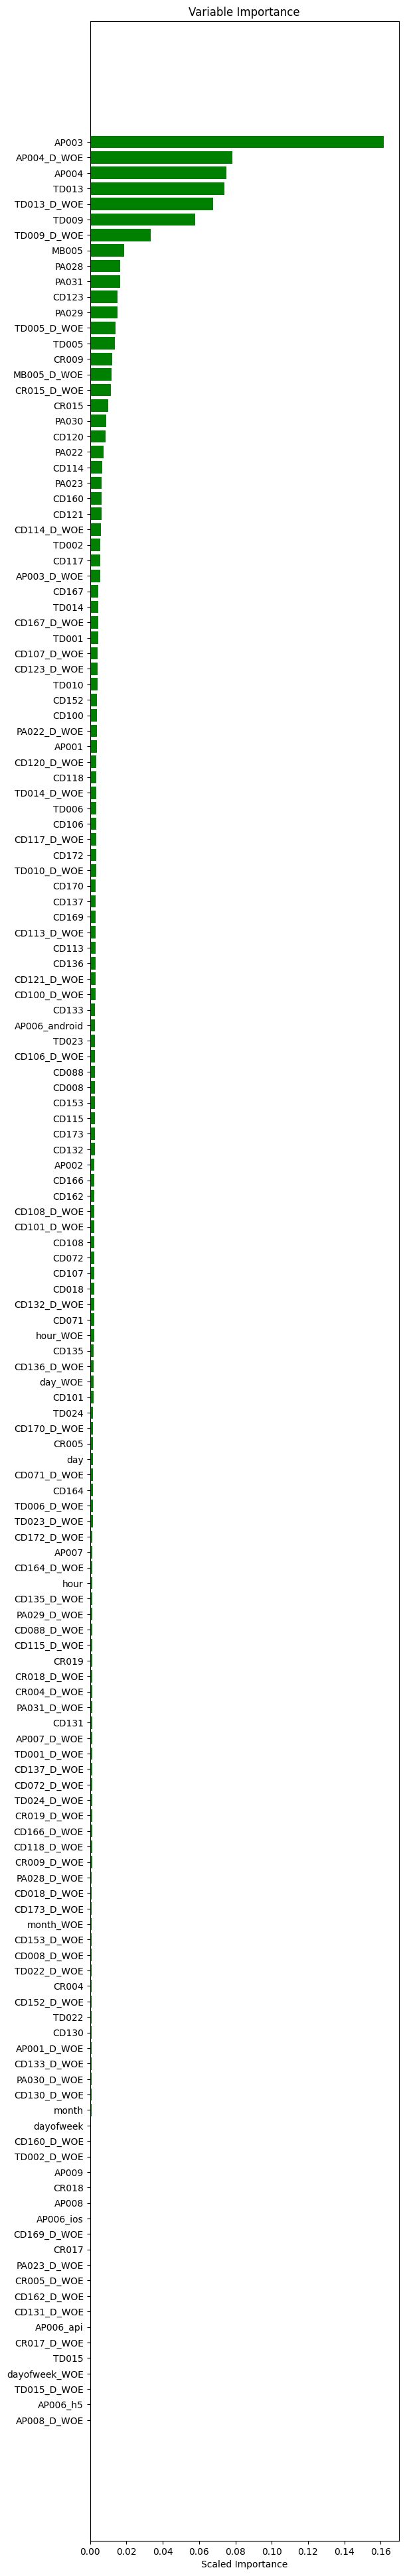

In [114]:
    plt.rcdefaults()
    variables = list(res.keys())
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/3))
    scaled_importance = list(res.values())
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

In [72]:
from heapq import nlargest

get the top ten important variable

In [115]:
top_ten = nlargest(10, res, key = res.get)

In [116]:
X_train = X_train[top_ten]
X_test = X_test[top_ten]

#### Model 2: top ten variable

In [117]:
model1  = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model1.fit(X_train, Y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

#### Get Variable importance for second model 

In [118]:
importance = model1.feature_importances_
variables = X_train.columns
res = {variables[i]: importance[i] for i in range(len(variables))}
res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1],reverse=True)}

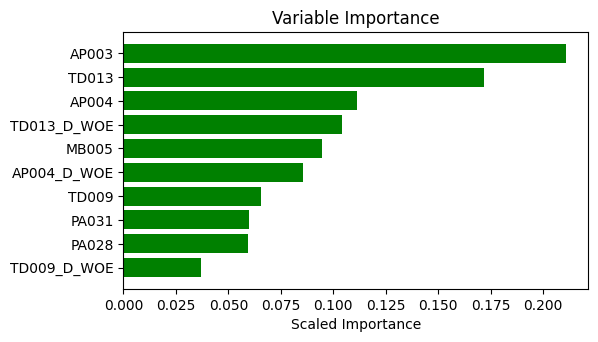

In [119]:
    plt.rcdefaults()
    variables = list(res.keys())
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/3))
    scaled_importance = list(res.values())
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

Having fewer variables can help avoid overfitting in some cases and can generalize better. Hence,these features were chosen to make the process faster and interpretability simpler.

## SHAP Values
SHAP values are used whenever there is a complex model and there is a need to understand what decisions the model is making. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction made if that feature took some baseline value.

In order to asess these values, we are going to visualize the following plots:

* The summary_plot
* The dependence_plot
* The force_plot for 4 individual observations

In [120]:
import shap
shap_values = shap.TreeExplainer(model1).shap_values(X_train)

### Summary Plot

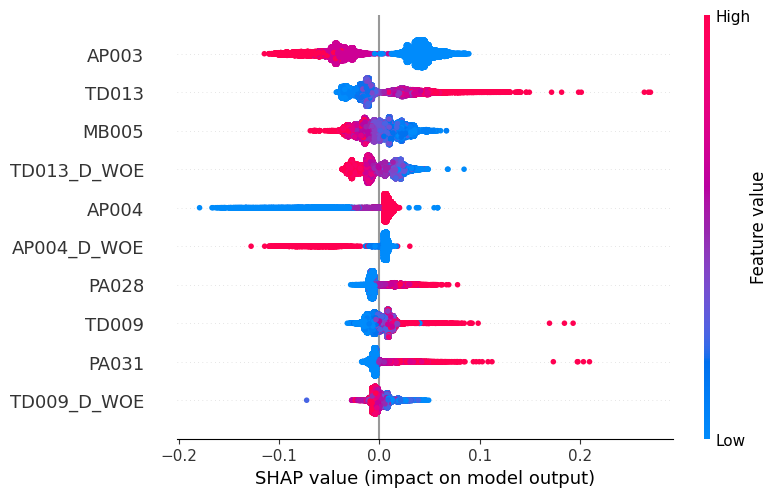

In [121]:
shap.summary_plot(shap_values, X_train)

* AP003 is the most important feature, it inversely correlated to the outcome. Higher the value lower the risk of default.

* We can see that TD013 is the second most important feature. It is positively correlates with the prediction, majority of the high values in this feature are associated with a high SHAP value.This could imply that higher the TD013 value could have higher chances of default. Non Fradulant activity can be associated with lower TD013 values. The features TD009, PA028, PA031.

* The variable AP004 has low values associated with high SHAP values, which could mean that lower values contribute to fradulant activity, and higher values have less chance of default.

* The impact of some of the variable is centred around zero and need to be better explored and re-evaluated while modelling

### The Dependance Plot
Lets plot the dependance plot for some the variables to highlight their impact on the outcome and their relationship to another variable.

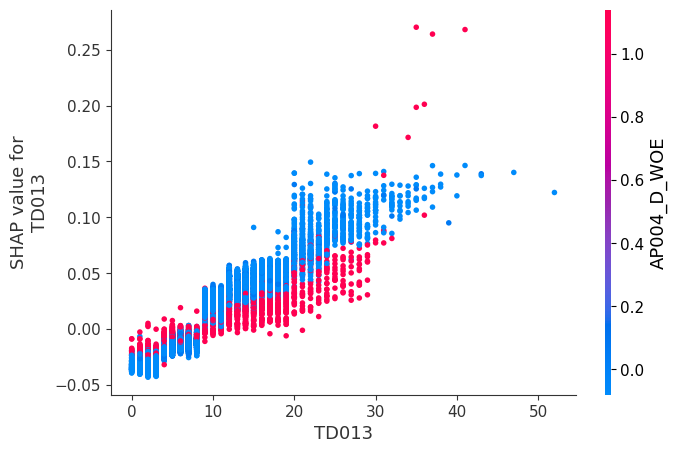

In [148]:
shap.dependence_plot('TD013', shap_values, X_train)

We can see that TD013 is positively correlated with the outcome and the variable that it highly interacts with is AP004_D_WOE. However, the effect of interaction can be observed clearly, they are inversely correlated to each other. Higher the TD013 value, lower the value of AP004_D_WOE.

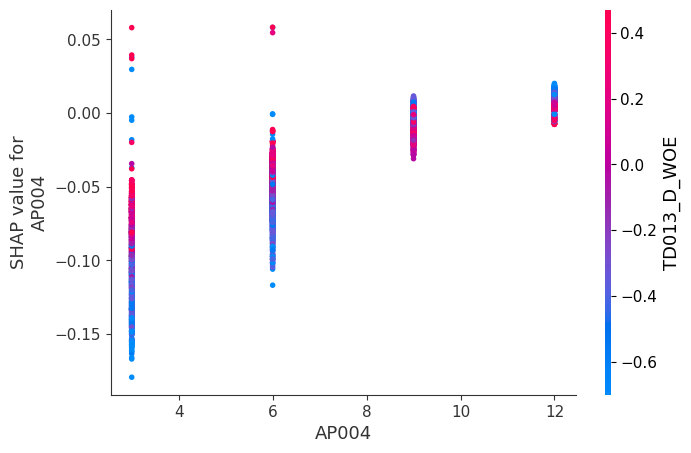

In [153]:
shap.dependence_plot('AP004', shap_values, X_train)

We observe that this is not a continuous variable. It has discrete levels, which are associated with certain SHAP values/ output variable. We can see that there is a general linearly negative trend. Lower values of AP004 have lower chance of defaulting and vice versa. The interacting variable here is TD013_D_WOE. 

We can see that for AP004 = 3, and a low value of TD013_D_WOE, SHAP values are low and hence have lower chance of default. 

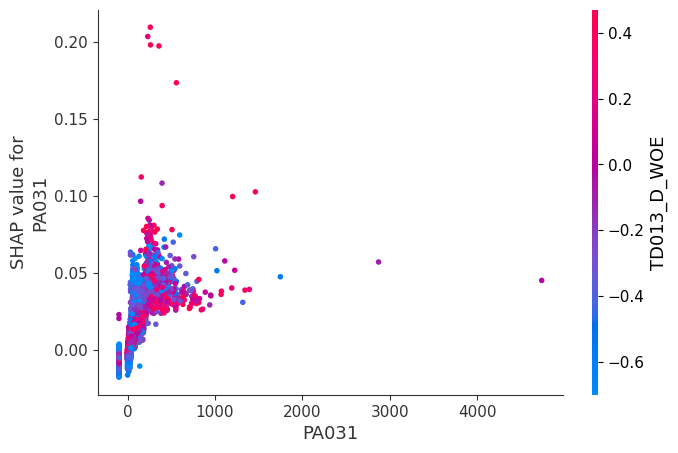

In [149]:
shap.dependence_plot('PA031', shap_values, X_train)

This is a clear example where no strong insight can be derived. Interaction effect with PA031 is not very obvious. This is one variable that may be removed from the training set, since it may confound the model, especially considering the fact that this has a relatively high feature importance value.

### Force Plots - Individual SHAP Value Plot for Local Interpretability
While the above two types of plots indicate the global interpretability(gives insights about features), force plots give us insights on impact of features on individual instances.

In [123]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model1.predict(X_output),2)

In [142]:
# Randomly pick some observations
random_picks = np.arange(1,400,40) # Every 50 rows
S = X_output.iloc[random_picks]
S

,AP003,AP004_D_WOE,AP004,TD013,TD013_D_WOE,TD009,TD009_D_WOE,MB005,PA028,PA031,predict
74683,1.0,-0.08,12.0,4.0,0.22,2.0,0.39,16.0,-98.000000,-98.0,0.16
31750,1.0,-0.08,12.0,18.0,-0.70,9.0,-0.35,5.0,-98.000000,-98.0,0.35
2371,3.0,-0.08,12.0,12.0,-0.34,7.0,-0.18,5.0,-98.000000,-98.0,0.23
61928,1.0,-0.08,12.0,4.0,0.22,4.0,0.11,1.0,-98.000000,-98.0,0.23
69259,1.0,-0.08,12.0,10.0,-0.24,6.0,-0.10,6.0,-98.000000,-98.0,0.28
29912,4.0,-0.08,12.0,6.0,-0.02,3.0,0.24,5.0,-98.000000,-98.0,0.11
77849,1.0,-0.08,12.0,16.0,-0.56,6.0,-0.10,11.0,58.500000,67.2,0.35
51075,1.0,-0.08,12.0,7.0,-0.09,8.0,-0.27,8.0,135.666667,50.0,0.35
59653,3.0,-0.08,12.0,1.0,0.71,1.0,0.62,8.0,-98.000000,-98.0,0.09
54589,4.0,-0.08,12.0,25.0,-0.70,25.0,-0.71,1.0,30.000000,30.0,0.40


In [143]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model1)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [147]:
shap_plot(5)

We can see from the plot above that all the features except AP004 and engineered feature AP004_D_WOE are tending the prediction towards a lower probability of default. We can see that AP003 is the most important feature and from the plots above that suggest a positive correlation with the output, is clearly seen in effect here

In [146]:
shap_plot(7)

We can see from the above plot that lower AP003 value(1) as opposed to value 3 in the previous example is pulling it towards possible default. It again reassures the fact that AP003 is inversely correlated

In [145]:
shap_plot(8)

Again. We can see from the plot above that all the features except AP004 and engineered feature AP004_D_WOE are tending the prediction towards a lower probability of default. However as oppose to the first example we find that TD013 which is the second most important features has a greater impact.

In [144]:
shap_plot(9)

We can see from the above plot that higher the TD013 value, 25 as opposed to value 1 in the previous example is pulling it towards possible default. It again reassures the fact that TD013 is inversely correlated

## Conclusion

* SHAP values and SHAP visualizations help understand not only the importance but also effect of each variable in the model and every individual case.

* The summay plot and dependance plot provides us with a global interpretation from a high level and the force plots provide with a much granular understanding ie local interpretation.

* Some anomalies may occur with regards to features predicting against the expectation based on observed correlation patterns. These can be exposed by observing the force plots.
